Rusty Bargain is a used car sales service that is developing an app to attract new customers. With this app, you can quickly find out your car's market value. You have access to the history, technical specifications, trim levels, and prices. You need to create a model that determines the market value.

Rusty Bargain is interested in:

*The quality of the prediction
*The speed of the prediction
*The time required for training

## Data Preparation

In [2]:
import pandas as pd 
import seaborn as sns
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

In [3]:
df = pd.read_csv('/Users/pauli/Documents/Data/rusty_bargain/car_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

The data types are correct. Let's change the column names to make it easier to process the data and write the code.

In [4]:
df = df.rename(columns={
    'DateCrawled': 'date_crawled', 
    'Price': 'price', 
    'VehicleType': 'vehicle_type', 
    'RegistrationYear': 'reg_year', 
    'Gearbox': 'gearbox', 
    'Power': 'power', 
    'Model': 'model', 
    'Mileage': 'mileage', 
    'RegistrationMonth': 'reg_month', 
    'FuelType': 'fuel_type', 
    'Brand': 'brand', 
    'NotRepaired': 'not_repaired', 
    'DateCreated': 'date_created', 
    'NumberOfPictures': 'n_pictures', 
    'PostalCode': 'postal_code', 
    'LastSeen': 'last_seen'
})

In [5]:
df.isna().sum()

date_crawled        0
price               0
vehicle_type    37490
reg_year            0
gearbox         19833
power               0
model           19705
mileage             0
reg_month           0
fuel_type       32895
brand               0
not_repaired    71154
date_created        0
n_pictures          0
postal_code         0
last_seen           0
dtype: int64

There is quite a bit of missing data in different columns, let's calculate what percentage of the data would be removed if we got rid of the missing data:

In [6]:
df_drop = (df.dropna().shape[0])/(df.shape[0])
df_drop

0.6936667710776055

If we remove missing data, we would eliminate about 30% of the data, which is a large representation of the data. For this reason, we'll fill in the missing data with the most common data from its respective column.

In [7]:
df['vehicle_type'].value_counts()

vehicle_type
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: count, dtype: int64

In [8]:
df['gearbox'].value_counts()

gearbox
manual    268251
auto       66285
Name: count, dtype: int64

In [9]:
df['model'].value_counts()

model
golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 250, dtype: int64

In the case of model, it will be replaced with other, since this covers many models.

In [10]:
df['fuel_type'].value_counts()

fuel_type
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64

In [11]:
df['not_repaired'].value_counts()

not_repaired
no     247161
yes     36054
Name: count, dtype: int64

In [12]:
#Fill out values

df['vehicle_type'] = df['vehicle_type'].fillna('sedan')
df['gearbox']= df['gearbox'].fillna('manual')
df['model']= df['model'].fillna('model')
df['fuel_type']= df['fuel_type'].fillna('petrol')
df['not_repaired']= df['not_repaired'].fillna('no')

In [13]:
#Check that there are no missing values

df.isna().sum()

date_crawled    0
price           0
vehicle_type    0
reg_year        0
gearbox         0
power           0
model           0
mileage         0
reg_month       0
fuel_type       0
brand           0
not_repaired    0
date_created    0
n_pictures      0
postal_code     0
last_seen       0
dtype: int64

We're going to remove the columns that aren't necessary, since they don't affect the price, so the model has less data to process.

In [14]:
cols_to_drop = ['date_crawled', 'date_created', 'last_seen', 'postal_code', 'n_pictures']

df = df.drop(columns=cols_to_drop)

df.head()

,price,vehicle_type,reg_year,gearbox,power,model,mileage,reg_month,fuel_type,brand,not_repaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,model,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Now, let's investigate whether the price has outliers that could affect the model.

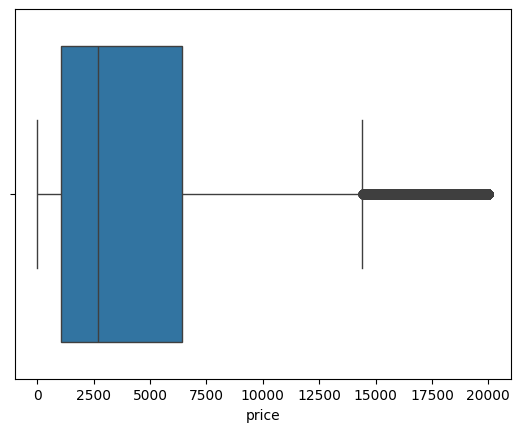

In [15]:
sns.boxplot(x=df['price'])
plt.show()

In [16]:
#Delete outliers 

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

Now, we perform a correlation analysis, to find out what influences the price.

In [17]:
corr_matrix = df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

ValueError: could not convert string to float: 'sedan'

We observed that price has a negative correlation with mileage (-0.27), meaning that higher mileage indicates a lower price. Likewise, it has a low positive correlation with power (0.14), indicating that cars with more power tend to have higher prices, but the relationship is not very strong.
The remaining characteristics do not show a significant correlation.
After this analysis, it was decided to eliminate the month of registration since it has no impact on price.

In [ ]:
cols_to_drop = ['reg_month']

df = df.drop(columns=cols_to_drop)

df.head()

,price,vehicle_type,reg_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,no
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


**Data Transformation**

In [ ]:
# Coding of categorical variables

df = pd.get_dummies(df, columns=['vehicle_type', 'model', 'brand', 'fuel_type', 'gearbox', 'not_repaired'], drop_first=True)

## Model Training

Ideally, your project should have linear regression for sanity testing, a tree-based algorithm with hyperparameter tuning (preferably random forest), LightGBM with hyperparameter tuning (test a pair of ensembles), and CatBoost and XGBoost with hyperparameter tuning (optional).

### First, let's run a linear regression to perform a sanity test on the model.

In [ ]:
#Standardize data

scaler = StandardScaler()
df[['mileage', 'power', 'reg_year']] = scaler.fit_transform(df[['mileage', 'power', 'reg_year']])

In [ ]:
X= df.drop(['price'], axis=1)
y= df['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

In [ ]:
model = LinearRegression()
start_time = time.time()
model.fit(X_train, y_train)

pred_start_time= time.time()
y_pred = model.predict(X_test)
train_time = time.time() - start_time
pred_time= time.time()- pred_start_time

rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'Training time: {train_time:.4f} segundos')
print(f'Prediction time: {pred_time:.4f} segundos')

Error cuadrático medio (RMSE): 2622.095823469635
Coeficiente de determinación (R2): 0.4289882736646342
Tiempo de entrenamiento: 9.6999 segundos
Tiempo de predicción: 0.1088 segundos


### Random Forest.


In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=15, n_jobs=-1)

start_time = time.time()
rf_model.fit(X_train, y_train)

pred_start_time= time.time()
y_pred = rf_model.predict(X_test)
train_time = time.time() - start_time
pred_time= time.time()- pred_start_time


rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'Training time: {train_time:.4f} segundos')
print(f'Prediction time: {pred_time:.4f} segundos')


Error cuadrático medio (RMSE): 1465.5752112631915
Coeficiente de determinación (R2): 0.821612618371888
Tiempo de entrenamiento: 314.3150 segundos
Tiempo de predicción: 2.4902 segundos


It has the lowest error so far, indicating that the model makes good predictions, however the runtime is extremely high, making it inefficient.

### Linear regression with stochastic gradient descent


In [ ]:
class SGDLinearRegression:
    def __init__(self, step_size, epochs, batch_size, reg_weight):
        self.step_size = step_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.reg_weight = reg_weight

    def fit(self, X_train, y_train):
        X = np.concatenate(
            (np.ones((y_train.shape[0], 1)), X_train), axis=1
        )
        y = y_train
        w = np.zeros(X.shape[1]).astype('float64')
        
        for _ in range(self.epochs):
            batches_count = X.shape[0] // self.batch_size
            for i in range(batches_count):
                begin = i * self.batch_size
                end = (i + 1) * self.batch_size
                X_batch = X[begin:end, :]
                y_batch = y[begin:end]
                
                gradient = (2 * X_batch.T.dot(X_batch.dot(w) - y_batch)/ X_batch.shape[0]).astype('float64')
                
                reg = 2 * w.copy()
                reg[0] = 0
                
                gradient += self.reg_weight * reg
                
                w -= self.step_size*gradient

        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, X_test):
        return X_test.dot(self.w) + self.w0

In [ ]:
#Entrenar el modelo 

model = SGDLinearRegression(0.01, 10, 100, 0)
start_time = time.time()
model.fit(X_train, y_train)
pred_start_time= time.time()
pred_test = model.predict(X_test)
train_time = (time.time()-start_time)
pred_time= time.time()- pred_start_time
mse = root_mean_squared_error(pred_test, y_test)
rmse = np.sqrt(mse)

print(f' R2: {r2_score(y_test, pred_test).round(4)}.')
print(f' RMSE: {rmse}.')
print(f'Training Time:{train_time} segundos.')
print(f'Prediction time: {pred_time:.4f} segundos')

 Coeficiente de determinación (R2): 0.4093.
 Error cuadrático medio (RMSE): 2666.913041416653.
Tiempo de entrenamiento:33.25821852684021 segundos.
Tiempo de predicción: 0.0986 segundos


The R2 in this model indicates that it only explains 40.93% of the price variability. This is significantly lower than other models, suggesting low predictive power.
The error is quite high.

### Training with LightGBM

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}

# Create training dataset
train_data = lgb.Dataset(X_train, label=y_train)

start_time = time.time()
model = lgb.train(params, train_data, num_boost_round=100)


pred_start_time= time.time()
y_pred = model.predict(X_test)

train_time = time.time() - start_time
pred_time= time.time()- pred_start_time

rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'Train time:{train_time} segundos.')
print(f'Prediction time: {pred_time:.4f} segundos')


Error cuadrático medio (RMSE): 1544.0446781755165
Coeficiente de determinación (R2): 0.8019988853255258
Tiempo de entrenamiento:5.0067315101623535 segundos.
Tiempo de predicción: 0.5072 segundos


In [ ]:
# Configure and train the LightGBM model with two additional sets of hyperparameters
params_1 = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 40,
    'verbose': -1
}

params_2 = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 20,
    'verbose': -1
}

for i, params in enumerate([params_1, params_2], 1):
    print(f'Training LightGBM with hyperparameters {i}')
    train_data = lgb.Dataset(X_train, label=y_train)
    start_time = time.time()
    model = lgb.train(params, train_data, num_boost_round=100)
    
    pred_start_time= time.time()
    y_pred = model.predict(X_test)
    pred_time= time.time()- pred_start_time
    train_time = time.time() - start_time
    rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f'LightGBM {i} - RMSE: {rmse}')
    print(f'LightGBM {i} - R2: {r2}')
    print(f'LightGBM {i} - Train time: {train_time:.4f} secs')
    print(f'Prediction time: {pred_time:.4f} secs')

Entrenando modelo LightGBM con conjunto de hiperparámetros 1
LightGBM 1 - Error cuadrático medio (RMSE): 1582.3616587925917
LightGBM 1 - Coeficiente de determinación (R2): 0.7920497666534168
LightGBM 1 - Tiempo de entrenamiento: 5.5947 segundos
Tiempo de predicción: 0.5905 segundos
Entrenando modelo LightGBM con conjunto de hiperparámetros 2
LightGBM 2 - Error cuadrático medio (RMSE): 1539.5978392788581
LightGBM 2 - Coeficiente de determinación (R2): 0.8031377269454439
LightGBM 2 - Tiempo de entrenamiento: 4.1865 segundos
Tiempo de predicción: 0.4075 segundos


The original parameter set strikes a good balance between accuracy and training time. The second set has worse accuracy and takes longer to train, so it's not the best option. The third option has the lowest RMSE, the best R2, and the shortest training time, so we chose these hyperparameters to test the model.


## Model Analysis 

In [ ]:
# Optimal settings for LightGBM
params_2 = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 20,
    'verbose': -1
}


start_time = time.time()
model = lgb.train(params_2, train_data, num_boost_round=100)

pred_start_time= time.time()
y_test_pred = model.predict(X_test)
pred_time= time.time()- pred_start_time
train_time = time.time() - start_time

test_rmse = np.sqrt(root_mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Mostrar resultados
print(f'LightGBM - RMSE: {test_rmse}')
print(f'LightGBM - R2: {test_r2}')
print(f'LightGBM - Train time: {train_time:.4f} segundos')
print(f'Prediction time: {pred_time:.4f} segundos')



LightGBM - Error cuadrático medio en test (RMSE): 1539.5978392788581
LightGBM - Coeficiente de determinación en test (R2): 0.8031377269454439
LightGBM - Tiempo de entrenamiento: 2.4924 segundos
Tiempo de predicción: 0.4015 segundos


For the final test, the RMSE obtained is 1539.60, which indicates the average error in predicting vehicle prices.
The R2 is 0.8031, meaning that the model explains approximately 80.31% of the variability in car prices, suggesting that the model has good predictive capacity.
The training time is 2.49 seconds, which is significantly faster than previously trained models.

# Conclusions

After evaluating multiple models, LightGBM proved to be the best option due to its excellent balance between accuracy and efficiency. In the final test, it obtained a coefficient of determination of 0.8031 and an RMSE of 1539.60, indicating performance almost as good as the Random Forest, but with shorter times. <br>
While the Random Forest took 314.32 seconds to train and 2.49 seconds to predict, LightGBM achieved a training time of only 2.49 seconds and a prediction time of 0.40 seconds, making it much more efficient for production and real-time applications. On the other hand, SGD, although fast, showed very poor performance with an R2 of just 0.4093 and an RMSE of 2666.91, which rules it out as a viable option. In conclusion, LightGBM is the most suitable model in this case, as it offers competitive accuracy with optimal training and prediction times, making it ideal for practical applications that require a balance between performance and speed.